# 1. Installing Dependencies

In [1]:
!pip install tensorflow

  Using cached tensorboard-2.11.0-py3-none-any.whl (6.0 MB)
  Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)
  Using cached tensorflow_estimator-2.11.0-py2.py3-none-any.whl (439 kB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.10.0
    Uninstalling tensorflow-estimator-2.10.0:
      Successfully uninstalled tensorflow-estimator-2.10.0
  Attempting uninstall: keras
    Found existing installation: keras 2.10.0
    Uninstalling keras-2.10.0:
      Successfully uninstalled keras-2.10.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.10.1
    Uninstalling tensorboard-2.10.1:
      Successfully uninstalled tensorboard-2.10.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-gpu 2.10.1 requires keras<2.11,>=2.10.0, but you have keras 2.11.0 which is incompatible.
tensorflow-gpu 2.10.1 requires tensorboard<2.11,>=2.10, but you have tensorboard 2.11.0 which is incompatible.
tensorflow-gpu 2.10.1 requires tensorflow-estimator<2.11,>=2.10.0, but you have tensorflow-estimator 2.11.0 which is incompatible.


In [2]:
!pip install tensorflow-gpu

  Using cached tensorflow_estimator-2.10.0-py2.py3-none-any.whl (438 kB)
  Using cached tensorboard-2.10.1-py3-none-any.whl (5.9 MB)
  Using cached keras-2.10.0-py2.py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully uninstalled tensorflow-estimator-2.11.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.11.0
    Uninstalling tensorboard-2.11.0:
      Successfully uninstalled tensorboard-2.11.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.11.0 requires keras<2.12,>=2.11.0, but you have keras 2.10.0 which is incompatible.
tensorflow-intel 2.11.0 requires tensorboard<2.12,>=2.11, but you have tensorboard 2.10.1 which is incompatible.
tensorflow-intel 2.11.0 requires tensorflow-estimator<2.12,>=2.11.0, but you have tensorflow-estimator 2.10.0 which is incompatible.


In [3]:
!pip install opencv-python matplotlib

# 2. Importing Dependencies

In [1]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

# 3. Create Folders for Data

In [3]:
# Paths
POSITIVE_PATH = os.path.join('data', 'positive')
NEGATIVE_PATH = os.path.join('data', 'negative')
TESTED_PATH = os.path.join('data', 'tested')
# Make the directories
os.makedirs(POSITIVE_PATH)
os.makedirs(NEGATIVE_PATH)
os.makedirs(TESTED_PATH)

# 4. Collect Positive and Tested Images

In [4]:
# Import uuid library to generate unique image names --> Like Guid in C#
import uuid
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect Tested 
    if cv2.waitKey(1) == ord('t'):
        # Create the unique file path & name
        imgname = os.path.join(TESTED_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POSITIVE_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # To Exit
    if cv2.waitKey(1) == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [8]:
# 9 more images with => different brightness, contrast, sdies, quality, saturation
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data
import os
import uuid
"""
Test one iamge first
img_path = os.path.join(TESTED_PATH, '0c55e753-6fe7-11ed-9966-f85ea0be83df.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)
for image in augmented_images:
    cv2.imwrite(os.path.join(TESTED_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())
"""
# Run once for POSITIVE_PATH and once for TESTED_PATH
for file_name in os.listdir(os.path.join(TESTED_PATH)):
    img_path = os.path.join(TESTED_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(TESTED_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# 5. Preprocessing - Scale and Resize

In [115]:
# Take only 3000 images
test = tf.data.Dataset.list_files(TESTED_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POSITIVE_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEGATIVE_PATH+'\*.jpg').take(300)

In [116]:
# Function for Scaling and Resizing
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [117]:
# Testing fun preprocess
dir_test = test.as_numpy_iterator()
print(dir_test.next())

b'data\\tested\\f80cfbe2-6fea-11ed-88aa-f85ea0be83df.jpg'


In [118]:
img = preprocess('data\\tested\\0c8d7ff0-6feb-11ed-9b9e-f85ea0be83df.jpg')
img.numpy().max()

0.8473039

In [ ]:
dataset.map(preprocess)

# 6. Labelled Dataset

In [119]:
# (test, positive) => 1,1,1,1,1
# (test, negative) => 0,0,0,0,0
positives = tf.data.Dataset.zip((test, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(test)))))
negatives = tf.data.Dataset.zip((test, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(test)))))
data = positives.concatenate(negatives)
samples = data.as_numpy_iterator()
exampple = samples.next()
exampple

(b'data\\tested\\fc8cfc31-6fea-11ed-a16b-f85ea0be83df.jpg',
 b'data\\positive\\279710dd-6fe9-11ed-90c3-f85ea0be83df.jpg',
 1.0)

# 7. Spliting Train and Test Data

In [120]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [121]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

# Training Data
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

# Testing Data
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 8. Building Model

### Build Embedding Layer

In [122]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_20 (Conv2D)          (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 46, 46, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 20, 20, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 17, 17, 128)       26

### Build Distance Layer

In [123]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

### Make Last Part of The Model

In [124]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 9. Model Training

In [125]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

# Establish Checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

### Build Train Step Function

In [126]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

### Build Training Loop

In [127]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

### Finally Train the model

In [128]:
# 50 iteratoin per image
EPOCHS = 20
train(train_data, EPOCHS)


 Epoch 1/20
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 730s 27s/step
0.5589471 0.17874396 1.0

 Epoch 2/20
27/27 [==============================] - 757s 28s/step
0.21998857 0.8779343 0.98421055

 Epoch 3/20
27/27 [==============================] - 736s 27s/step
0.11720561 0.9302326 0.98039216

 Epoch 4/20
27/27 [==============================] - 735s 27s/step
0.37811282 0.93658537 0.97959185

 Epoch 5/20
27/27 [==============================] - 681s 25s/step
0.24606244 0.9362745 0.9845361

 Epoch 6/20
1/1 [==============================] - 2s 2s/step


27/27 [==============================] - 679s 25s/step
0.007469005 0.9530516 0.9854369

 Epoch 7/20
27/27 [==============================] - 670s 25s/step
0.34897435 0.9906977 0.9953271

 Epoch 8/20
27/27 [==============================] - 672s 25s/step
0.007069304 0.96713614 0.9951691

 Epoch 9/20
27/27 [==============================] - 679s 25s/step
0.0037467498 0.99523807 1.0

 Epoch 10/20
27/27 [==============================] - 673s 25s/step
0.00037549954 0.9902439 0.99509805

 Epoch 11/20
27/27 [==============================] - 676s 25s/step
0.029620284 1.0 1.0

 Epoch 12/20
1/1 [==============================] - 2s 2s/step


27/27 [==============================] - 674s 25s/step
0.00017923048 1.0 1.0

 Epoch 13/20
27/27 [==============================] - 673s 25s/step
0.0007003712 1.0 1.0

 Epoch 14/20
27/27 [==============================] - 678s 25s/step
1.6436356e-05 1.0 1.0

 Epoch 15/20
27/27 [==============================] - 680s 25s/step
0.0024068358 1.0 1.0

 Epoch 16/20
27/27 [==============================] - 676s 25s/step
0.0021318055 1.0 1.0

 Epoch 17/20
1/1 [==============================] - 2s 2s/step


27/27 [==============================] - 665s 25s/step
7.181742e-05 1.0 1.0

 Epoch 18/20
27/27 [==============================] - 681s 25s/step
0.0024384356 1.0 1.0

 Epoch 19/20
27/27 [==============================] - 661s 24s/step
1.2174539e-05 1.0 1.0

 Epoch 20/20
27/27 [==============================] - 678s 25s/step
0.0012896337 1.0 1.0


# 10. Evaluate Model

In [129]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

# Make Predictions
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 2s 2s/step


In [130]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1]

In [131]:
y_true

array([0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1.],
      dtype=float32)

In [132]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [133]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [134]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 495ms/step
1.0 1.0


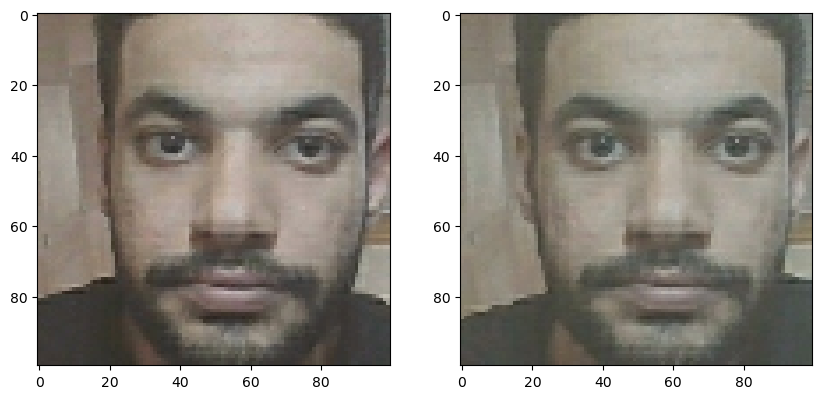

In [137]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[1])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[1])

# Renders cleanly
plt.show()

# 11. Save Model

In [146]:
# Save weights
siamese_model.save('ann_model.h5')

In [147]:
L1Dist

__main__.L1Dist

In [148]:
# Reload model 
siamese_model = tf.keras.models.load_model('ann_model.h5', 
                                           custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [149]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 1s 650ms/step


array([[2.1879042e-04],
       [9.9995697e-01],
       [8.2321616e-09],
       [9.9999970e-01]], dtype=float32)

In [150]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 12. Real Time Test

In [153]:
# Verification Function
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

# OpenCV Real Time Verification
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 386ms/step
False
